In [1]:
##** must be installed locally /usr/local/bin/mkdssp, not in your conda env ***
!which mkdssp
#!mkdssp  2DKE_edit.pdb

/usr/local/bin/mkdssp


In [2]:
model_path = '/ibmm_data/TemBERTure/model/BERT_cls/BEST_MODEL/lr_1e-5_headropout01/output/best_model_epoch4_adapterslibrary/'
out_path = '/ibmm_data/TemBERTure/model/BERT_cls/BEST_MODEL/lr_1e-5_headropout01/ANALYSIS/SASA_SCORE_DISULFIDEBONDS_SALTBRIDGES+ATTENTION_ANALYSIS/pdbs_only_correctly_predicted/temberture'
data_path ='/ibmm_data/TemBERTure/model/BERT_cls/BEST_MODEL/lr_1e-5_headropout01/ANALYSIS/AA_ENRICHMENT_VS_HAS/pdbs_data_only_correct_one/'
#!cd  '/ibmm_data/TemBERTure/model/BERT_cls/BEST_MODEL/lr_1e-5_headropout01/ANALYSIS/SASA_SCORE_DISULFIDEBONDS_SALTBRIDGES/pdbs_only_correctly_predicted'
!mkdir img

mkdir: cannot create directory ‘img’: File exists


In [3]:
device ='cpu'

In [4]:
### example
#1. using class
#from temBERTure.temBERTure import TemBERTure
#classifier = TemBERTure(adapter_path='/ibmm_data/TemBERTure/model/BERT_cls/BEST_MODEL/lr_1e-5_headropout01/output/best_model_epoch4 (copy)/',task='classification',device='cuda:3')
#classifier.predict([pdb_thermo['COMPLETE_SEQ'][15]])
#2. transformers pipeline
#model_classification=TemBERTure_for_classification(model_path) # to compute classification score
#from transformers import pipeline
#pipe = pipeline("text-classification",model=model_classification,tokenizer='Rostlab/prot_bert_bfd')

In [5]:
# SASA
#https://biopython.org/docs/dev/api/Bio.PDB.SASA.html
#https://www.google.com/search?q=SASA+protein&sxsrf=ALiCzsYMW3POZZINcRQsZX66P4GoJSROnw:1669881805788&source=lnms&tbm=isch&sa=X&ved=2ahUKEwju7ua--tf7AhUei_0HHUWeDeMQ_AUoAXoECAEQAw&biw=1990&bih=1020&dpr=1.25#imgrc=uMFPC-SOr8m9jM
#it gives me the score of exposion, circa 0 in the core since it is not expose and higher and higher more the area is expose
# check if it is a discrimination in both sense

## *** UPDATE 06/02/2022 ******
#Use DSSP (with Biopython) to extract the relative solvent accessibility (RSA) [index 3 in the output tuple]
#https://biopython.org/docs/1.75/api/Bio.PDB.DSSP.html
#Let's define buried residue as any residue with a RSA < 25%
#https://www.biostars.org/p/9481863/
#wE should just extract the ACC column
#This is the absolute value, which you should divide by:
'''normalizing_values={'A' : 106,
'C' : 135,
'D' : 163,
'E' : 194,
'F' : 197,
'G' : 84,
'H' : 184,
'I' : 169,
'K' : 205,
'L' : 164,
'M' : 188,
'N' : 157,
'P' : 136,
'Q' : 198,
'R' : 248,
'S' : 130,
'T' : 142,
'V' : 142,
'W' : 227,
'Y' : 222}'''
# normalizing values from  https://www.biostars.org/p/9518409/#9518448
# DSSP TERMINAL COMMAND: dssp -i 1hl9.pdb -o 1hl9.dssp
# however biopython facilitates things by returning with index 3 in the tuple the already normalized sasa score values ( ACC COLUMN IN THE .DDSP DIVIDED BY THE MAXIMUM VALUES PER AMINO ACID)
# Example:
'''from Bio.PDB import *
from Bio.PDB.DSSP import DSSP
import prody
#from sh import gunzip

#pdb = prody.parsePDB('1hl9',chain='A')

#gunzip('1hl9.pdb.gz')
parser = PDBParser()
io = PDBIO()
structure = parser.get_structure('X', '1hl9_edit.pdb') #using the pdb edited by prody to fix the structure and reading only the interested chain
model = structure[0]
dssp = DSSP(model, '1hl9_edit.pdb', dssp="dssp") #dssp='mkdssp'
dssp_out = list(dssp)
chain_dss= [lis for lis in dssp_out if lis]
res_name = [lis[1] for lis in dssp_out]
sasa_score = [lis[3] for lis in dssp_out]
res_name'''

## UPDATE 28/03
# DONE --> SASA could you plot the SASA score on a few PDB and see if the threshold between exposed and surfaces makes sense? We might have to increase the threshold or add a third level (e.g. expose, semi buried, core).
#for the high E, D, K, H and R, could you check if they form salt-bridges:
#http://www.ks.uiuc.edu/Research/vmd/plugins/saltbr/

## update 18/04
# add the extraction of disulfide bonds as well as we did for saltbridge using biotite library
## code from https://www.biotite-python.org/examples/gallery/structure/disulfide_bonds.html

## update 10/05
#add the category of aa types, this is an aggregate analisys in aa categories

## update
## perform a significance test, fisher exact test, on both single aa and aa types, meso and thermo separately
#The two categories are: Exposed vs Buried and High vs Low

'from Bio.PDB import *\nfrom Bio.PDB.DSSP import DSSP\nimport prody\n#from sh import gunzip\n\n#pdb = prody.parsePDB(\'1hl9\',chain=\'A\')\n\n#gunzip(\'1hl9.pdb.gz\')\nparser = PDBParser()\nio = PDBIO()\nstructure = parser.get_structure(\'X\', \'1hl9_edit.pdb\') #using the pdb edited by prody to fix the structure and reading only the interested chain\nmodel = structure[0]\ndssp = DSSP(model, \'1hl9_edit.pdb\', dssp="dssp") #dssp=\'mkdssp\'\ndssp_out = list(dssp)\nchain_dss= [lis for lis in dssp_out if lis]\nres_name = [lis[1] for lis in dssp_out]\nsasa_score = [lis[3] for lis in dssp_out]\nres_name'

# Notebook Prep

In [6]:
# General Libraries
import re
import pandas as pd
from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import json
import matplotlib

# Notebook Libraries
import math
from transformers import BertTokenizer, BertModel
from adapters import  BertAdapterModel
import torch
import torch.nn as nn
from transformers.modeling_utils import PreTrainedModel , PretrainedConfig

## Example: DSSP 

In [7]:
from Bio.PDB import MMCIFParser,PDBParser
from Bio.PDB.Residue import Residue
from Bio.PDB.Atom import Atom
from Bio.PDB.Chain import Chain
from Bio.PDB.Structure import Structure
from Bio.PDB.Model import Model
from Bio.PDB.PDBList import PDBList
from Bio.PDB.SASA import ShrakeRupley
from Bio.PDB.DSSP import DSSP
import Bio.PDB.PDBExceptions
import prody
from collections import OrderedDict

id =  "2DKE_A"

pdb_id,chain=id.rsplit('_')
pdb = prody.parsePDB(pdb_id,chain=chain)
#prot = pdb.select('protein')
pdb = pdb.select(f"protein and resid 1 to {pdb.select('pdbter').getResnums()[0]}")

print('')
print(f'Reading {pdb_id} with chain {chain}')
print('')

prody_seq=pdb.ca.getSequence()

####### SASA SCORE ##########

try:
  mse = pdb.select('resname MSE')
  mse.setResnames(["MET"]*len(mse))
except AttributeError:
  pass

prody.writePDB(pdb_id+'_edit.pdb', pdb)
parser = PDBParser()
structure = parser.get_structure('pdb', pdb_id+'_edit.pdb')


model = structure[0]
dssp = DSSP(model, pdb_id+'_edit.pdb', dssp="dssp") #dssp='mkdssp'
dssp_out = list(dssp)
chain_dss= [lis for lis in dssp_out if lis]
res_name = [lis[1] for lis in dssp_out]
sasa_score = [lis[3] for lis in dssp_out]
print(sasa_score)

@> Connecting wwPDB FTP server RCSB PDB (USA).


@> 2dke downloaded (2dke.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
@> 1970 atoms and 1 coordinate set(s) were parsed in 0.01s.



Reading 2DKE with chain A

[0.9386503067484663, 0.4146341463414634, 0.47692307692307695, 0.08536585365853659, 0.7816901408450704, 0.9745222929936306, 0.09230769230769231, 0.5461538461538461, 0.042682926829268296, 0.12234042553191489, 0.7426470588235294, 0.5915492957746479, 0.018292682926829267, 0.12738853503184713, 0.5073529411764706, 0.0, 0.0, 0.2878787878787879, 0.3181818181818182, 0.0, 0.0, 0.6036585365853658, 0.16981132075471697, 0.0, 0.09433962264150944, 0.5754716981132075, 0.12307692307692308, 0.03524229074889868, 0.29292929292929293, 0.6692307692307692, 0.08536585365853659, 0.5514705882352942, 0.18902439024390244, 0.5609756097560976, 0.7720588235294118, 0.24774774774774774, 0.7575757575757576, 0.07926829268292683, 0.18382352941176472, 0.8144329896907216, 0.4233128834355828, 0.006097560975609756, 0.36904761904761907, 0.5045045045045045, 0.06338028169014084, 0.4948453608247423, 0.14285714285714285, 0.5685483870967742, 0.12195121951219512, 0.8350515463917526, 0.6547619047619048, 0

In [8]:
# from 3 letters lowercase from biopython to single letter aa alphabet
from Bio import SeqUtils
aa_names=SeqUtils.IUPACData.protein_letters_3to1_extended
aa_names_upp=[aa.upper() for aa in aa_names]
#aa_names_upp
d = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
    'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N',
    'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W',
    'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}


## Example: Masks

In [9]:
## EXAMPLE
import prody
pdb = prody.parsePDB("1G9K")
prody_seq=pdb.ca.getSequence()
len(prody_seq)
res_id=pdb.ca.getResnames()
len(res_id)

@> Connecting wwPDB FTP server RCSB PDB (USA).
@> 1g9k downloaded (1g9k.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
@> 3755 atoms and 1 coordinate set(s) were parsed in 0.02s.


455

# CLS MODEL

In [10]:
!pwd

/ibmm_data/TemBERTure/model/BERT_cls/BEST_MODEL/lr_1e-5_headropout01/ANALYSIS/SASA_SCORE_DISULFIDEBONDS_SALTBRIDGES+ATTENTION_ANALYSIS/pdbs_only_correctly_predicted/temberture


In [11]:
##This command creates a symbolic link from the source directory /model/code/ to the destination directory 
!ln -s '/ibmm_data/TemBERTure/model/code/' '/ibmm_data/TemBERTure/model/BERT_cls/BEST_MODEL/lr_1e-5_headropout01/ANALYSIS/SASA_SCORE_DISULFIDEBONDS_SALTBRIDGES+ATTENTION_ANALYSIS/pdbs_only_correctly_predicted/temberture'

ln: failed to create symbolic link '/ibmm_data/TemBERTure/model/BERT_cls/BEST_MODEL/lr_1e-5_headropout01/ANALYSIS/SASA_SCORE_DISULFIDEBONDS_SALTBRIDGES+ATTENTION_ANALYSIS/pdbs_only_correctly_predicted/temberture/code': File exists


In [12]:
# to import the code 
import sys
sys.path.insert(0, '/ibmm_data/TemBERTure/model/code/') 
from temBERTure.temBERTure import TemBERTure
classifier = TemBERTure(adapter_path= model_path ,task='classification',device='cuda:3')
#classifier.predict([pdb_meso['COMPLETE_SEQ'][3]])
from analysis.sasa_utils import *

In [13]:
# Uploading the TemBERTure cls bert model and initialize it for attention analysis
model_bert = TemBERTure_for_attention(best_model_path=model_path) 
#print(model_bert)

MODEL WITH ADAPTER from /ibmm_data/TemBERTure/model/BERT_cls/BEST_MODEL/lr_1e-5_headropout01/output/best_model_epoch4_adapterslibrary/


In [14]:
## ** DO NOT USE : SEEMS THAT PIPELINE GIVES ONLY SOMETIMES AN ERROR LABEL AND SCORE **
#model_classification=TemBERTure_for_classification(model_path) # to compute classification score
#from transformers import pipeline
#pipe = pipeline(model=model_classification,tokenizer='Rostlab/prot_bert_bfd')
#pipe(pdb_meso['COMPLETE_SEQ'][3].replace('',' ')) # it gives you only label 0 also if is a thermophilic because he is a binary classification

# DATA

In [15]:
path=data_path

## PDB THERMO (only correctly predicted)

In [16]:
# THERMO PDB
# run the model on complete_seq and plot in the .pdb only the amino acid with mask 1
#pdb_thermo=pd.read_csv(path+'pdbs_thermo_cls_corr_predicted',header=None,sep=',')
pdb_thermo=pd.read_csv(path+'pdbs_thermo_cls_corr_predicted',header=None,sep=',')
pdb_thermo.columns=['PDB_ID','COMPLETE_SEQ','SEQ_MASK','LABEL','CLS_SCORE']
pdb_thermo

,PDB_ID,COMPLETE_SEQ,SEQ_MASK,LABEL,CLS_SCORE
0,1IN4_A,QFLRPKSLDEFIGQENVKKKLSLALEAAKMRGEVLDHVLLAGPPGL...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,1,0.930360
1,2Z1E_A,AGGEIMEELLRDVILKTLTLKSAGGIGLDALDDGATIPFGDKHIVF...,[1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. ...,1,0.999735
2,1TML_A,NDSPFYVNPNMSSAEWVRNNPNDPRTPVIRDRIASVPQGTWFAHHN...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,1,0.564142
3,1TWL_A,NPFHDLEPGPDVPEVVYAIIEIPKGSRNKYELDKKTGLLKLDRVLY...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,1,0.999206
4,1IDM_A,MKVAVLPGDGIGPEVTEAALKVLRALDEAEGLGLAYEVFPFGGAAI...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,1,0.999226
5,1Y6J_A,RSKVAIIGAGFVGASAAFTMALRQTANELVLIDVFKEKAIGEAMDI...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,1,0.832106
6,1EPZ_A,EFRFIKTSLDGAIIIEPEVYTDERGYFMETFNEAIFQENGLEVRFV...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,1,0.631386
7,1RIY_A,MNKKELIDRVAKKAGAKKKDVKLILDTILETITEALAKGEKIQIVG...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,1,0.997698
8,5ZX8_A,MFLVVGQGNPGERYARTRHNLGFMVLDRLGLSFRPRGEALVAEAEG...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,1,0.999947
9,1VLV_A,MSVNLKGRSLLTLLDFSPEEIRYLLDISKQVKMENRSKLRTERFKG...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,1,0.972860


In [17]:
### ** COMPUTE THE CLS LABEL AND SCORE **, NOT NECESSARY ANYMORE SINCE WE HAVE ALREADY THIS INFO IN THE DATA
# Apply the pipeline to each row in the 'COMPLETE_SEQ' column
#results = pdb_thermo['COMPLETE_SEQ'].str.replace('',' ').apply(lambda x: pipe(x))

# Extract 'label' and 'score' values into separate columns
#pdb_thermo['label'] = [0 if result[0]['score'] <=0.5 else 1 for result in results]
#pdb_thermo['score'] = [result[0]['score'] for result in results]
#pdb_thermo

## PDB MESO (only correctly predicted)

In [18]:
# MESO PDB
# run the model on complete_seq and plot in the .pdb only the amino acid with mask 1
pdb_meso=pd.read_csv(path+'pdbs_meso_cls_corr_predicted',header=None,sep=',')
pdb_meso.columns=['PDB_ID','COMPLETE_SEQ','SEQ_MASK','LABEL','CLS_SCORE']
pdb_meso

,PDB_ID,COMPLETE_SEQ,SEQ_MASK,LABEL,CLS_SCORE
0,6BLB_A,AIRPLKLADYIGQPSVREQMELFIHAARGRQEALDHTLIFGPPGLG...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,0,0.003616
1,2Z1U_A,TLLLDYGSGGRASHRLISDLFLRHFDNPILGTLNDAARLDLTGPLA...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,0,0.218385
2,1UP0_A,ANPLAGKPFYVDPASAAMVAARNANPPNAELTSVANTPQSYWLDQA...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,0,0.026884
3,6K21_A,SYNNIPAGKDAPNDIYVIIEIPANAAPIKYEIDKDSDALFVDRFMG...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,0,0.002263
4,3VML_A,SSYQIAVLAGDGIGPEVMAEARKVLKAVEARFGLNIEYTEYDVGGI...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,0,0.001266
5,1LLC_A,ASITDKDHQKVILVGDGAVGSSYAFAMVLQGIAQEIGIVDIFKDKT...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,0,0.016418
6,1RTV_A,MKATRLAIPDVILFEPRVFGDDRGFFFESYNQRAFEEACGHPVSFV...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,0,0.193056
7,4P3V_A,MNKSQLIDKIAAGADISKAAAGRALDAIIASVTESLKEGDDVALVG...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,0,0.002748
8,2Z2I_A,MAEPLLVVGLGNPGANYARTRHNLGFVVADLLAARLGAKFKAHKRS...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,0,0.007980
9,1DXH_A,AFNMHNRNLLSLMHHSTRELRYLLDLSRDLKRAKYTGTEQQHLKRK...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,0,0.070078


In [19]:
### ** COMPUTE THE CLS LABEL AND SCORE **, NOT NECESSARY ANYMORE SINCE WE HAVE ALREADY THIS INFO IN THE DATA
# Apply the pipeline to each row in the 'COMPLETE_SEQ' column
#preds = pdb_meso['COMPLETE_SEQ'].apply(lambda x: classifier.predict([x]))

# Extract 'label' and 'score' values into separate columns
#pdb_meso['label'] = [int(p[0]) for p in preds]
#pdb_meso['score'] = [float(p[1]) for p in preds]

In [20]:
import numpy as np
masks=pdb_meso.iloc[8].SEQ_MASK
masks=np.around(np.fromstring(masks[1:-1], sep=' ')).astype(int).tolist()
masks=list(masks[i] for i in masks if i == 1 )
print('all masks',len(masks))
print('masks ==1',)
print(len(pdb.ca.getBetas()))

all masks 179
masks ==1
455


# COMPUTATION: SASA SCORE, DISULFIDE BONDS, SALT BRIDGES

## THERMO
*** You will notice "MESO" as a prefix for all the arrays, etc. This is due to the fact that the main changes were made on the MESO part, and the THERMO data is the same. For the sake of consistency, I am using "MESO" everywhere, but the computations have been made on the THERMO data. ***

In [21]:
label = 'thermo'

In [22]:
%%capture
# 1 minute
## i.e. with disulfide bonds id 3F9Q 
##meso_HAS_disulfide --> 0 means is a core/surface residue but without disulfide bonds
#### HERE MUST BE PDB_THERMO ####
meso_baseline_sasa, meso_HAS_sasa,n_pdbs_processed,meso_HAS_disulfide, meso_ALL_disulfide = biotite_disulfide_bonds(pdb_thermo,model_bert,device) 

@> Connecting wwPDB FTP server RCSB PDB (USA).


@> 1in4 downloaded (1in4.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
@> 2599 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Connecting wwPDB FTP server RCSB PDB (USA).
@> 2z1e downloaded (2z1e.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
@> 2485 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Connecting wwPDB FTP server RCSB PDB (USA).
@> 1tml downloaded (1tml.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
@> 2843 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Connecting wwPDB FTP server RCSB PDB (USA).
@> 1twl downloaded (1twl.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
@> 1405 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Connecting wwPDB FTP server RCSB PDB (USA).
@> 1idm downloaded (1idm.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
@> 2679 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Connecting wwPDB FTP server RCSB PDB (USA).


In [23]:
print('Check # PDBS correctly processed',n_pdbs_processed) #24

Check # PDBS correctly processed 16


In [24]:
%%capture
## 1 minute
### *** WITH THIS CODE YOU ARE ALSO COMPUTING THE PDBs FOR THE ATTENTION AND FOR THE SASA ANALYSIS (FOR THE GALLERY) ***
meso_baseline_sasa2, meso_HAS_sasa2, n_pdbs_processed, meso_HAS_salt_bridge, meso_ALL_salt_bridge = biopython_sasa_residue_and_salt_bridges(pdb_thermo,model_bert,device,sasa_on_pdb=True,att_on_pdb=True)

@> Connecting wwPDB FTP server RCSB PDB (USA).


@> 1in4 downloaded (1in4.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
@> 2599 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Connecting wwPDB FTP server RCSB PDB (USA).
@> 2z1e downloaded (2z1e.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
@> 2485 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Connecting wwPDB FTP server RCSB PDB (USA).
@> 1tml downloaded (1tml.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
@> 2843 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Connecting wwPDB FTP server RCSB PDB (USA).
@> 1twl downloaded (1twl.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
@> 1405 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Connecting wwPDB FTP server RCSB PDB (USA).
@> 1idm downloaded (1idm.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
@> 2679 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Connecting wwPDB FTP server RCSB PDB (USA).


In [25]:
# check how many 0 o 1 ci sono nel salt_bridges dict
#dizionario = meso_ALL_salt_bridge.copy()
#conteggio = sum(sublista.count(0) for diz in dizionario.values() for sublista in diz.values())
#print("Il numero totale di 1 nel dizionario è:", conteggio)

In [26]:
print('Check # PDBS correctly processed',n_pdbs_processed) #24

Check # PDBS correctly processed 16


In [27]:
# saving the essentials arrays

import numpy as np
np.save(out_path + f'/{label}_HAS_sasa.npy',meso_HAS_sasa)
np.save(out_path + f'/{label}_baseline_sasa.npy',meso_baseline_sasa)
np.save(out_path + f'/{label}_HAS_salt_bridge.npy',meso_HAS_salt_bridge)
np.save(out_path + f'/{label}_ALL_salt_bridge.npy',meso_ALL_salt_bridge)
np.save(out_path + f'/{label}_HAS_disulfide.npy',meso_HAS_disulfide)
np.save(out_path + f'/{label}_ALL_disulfide.npy',meso_ALL_disulfide)

In [28]:
## for sanity check the following dictionary should be equal in pairs but the disulfide processed 1 more pdbs
#meso_baseline_sasa1, meso_HAS_sasa1,
#meso_baseline_sasa, meso_HAS_sasa,

dizionario1= meso_HAS_sasa.copy()
dizionario2 = meso_HAS_sasa2.copy()
# Verifica se i valori nei dizionari sono uguali
values_uguali = all(dizionario1[chiave] == dizionario2[chiave] for chiave in dizionario1)

if values_uguali:
    print("I valori nei dizionari sono uguali.")
else:
    print("I valori nei dizionari non sono uguali.")
    
dizionario1= meso_baseline_sasa.copy()
dizionario2 = meso_baseline_sasa2.copy()
# Verifica se i valori nei dizionari sono uguali
values_uguali = all(dizionario1[chiave] == dizionario2[chiave] for chiave in dizionario1)

if values_uguali:
    print("I valori nei dizionari sono uguali.")
else:
    print("I valori nei dizionari non sono uguali.")



I valori nei dizionari sono uguali.
I valori nei dizionari sono uguali.


In [29]:
import numpy as np

# Carica e converte gli array in dizionari
meso_HAS_sasa = dict(np.load(out_path + f'/{label}_HAS_sasa.npy', allow_pickle=True).tolist())
meso_baseline_sasa = dict(np.load(out_path + f'/{label}_baseline_sasa.npy', allow_pickle=True).tolist())
meso_HAS_salt_bridge = dict(np.load(out_path + f'/{label}_HAS_salt_bridge.npy', allow_pickle=True).tolist())
meso_ALL_salt_bridge = dict(np.load(out_path + f'/{label}_ALL_salt_bridge.npy', allow_pickle=True).tolist())
meso_HAS_disulfide = dict(np.load(out_path + f'/{label}_HAS_disulfide.npy', allow_pickle=True).tolist())
meso_ALL_disulfide = dict(np.load(out_path + f'/{label}_ALL_disulfide.npy', allow_pickle=True).tolist())


### FISHER exact test

In [30]:
'''
Null (H0): There is no association between gender and voting. They are independent.
Alternative (HA): A relationship between gender and voting exists in the population.
When your p-value is below your significance level (e.g., 0.05), reject the null hypothesis.
The sample data is strong enough to conclude that a relationship between the categorical variables exists in the population.
Knowing the value of one variable provides information about the value of the other variable.'''

#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fisher_exact.html
#two sided vs one side : https://stats.stackexchange.com/questions/325744/when-is-a-one-sided-test-used-versus-a-two-sided-test-in-a-fishers-exact-test
import numpy as np
table = np.array([[6, 2], [1, 4]])
#	The two categories are: Exposed(surface) vs Buried(core) and High vs Low
print(table)
from scipy.stats import fisher_exact

res = fisher_exact(table, alternative='two-sided')

res.pvalue

[[6 2]
 [1 4]]


0.10256410256410256

In [31]:
import numpy as np
from scipy.stats import fisher_exact

meso_aa_significant=[]
with open('THERMO_fisher_exact.txt', 'a') as f:
  f.write('------------------------------------------------------ \n THERMOPHILIC - Fisher exact test \n------------------------------------------------------ \n')
for aa in meso_baseline_sasa.keys():
  exposed_high=sum(meso_HAS_sasa[aa]['surface'])
  buried_high=sum(meso_HAS_sasa[aa]['core'])
  exposed_low=sum(meso_baseline_sasa[aa]['surface'])-sum(meso_HAS_sasa[aa]['surface'])
  buried_low=sum(meso_baseline_sasa[aa]['core'])-sum(meso_HAS_sasa[aa]['core'])
  table=np.array([[exposed_high, exposed_low], [buried_high, buried_low]])
  df = pd.DataFrame(table, index=['exposed','buried'], columns=['high att','low att'])
  res = fisher_exact(table, alternative='two-sided')
  significance='SIGNIFICANT (p-value < 0.05)' if res.pvalue < 0.05 else 'non significant (p-value > 0.05)'
  with open('THERMO_fisher_exact.txt', 'a') as f:
    dfAsString = df.to_string(header=True, index=True)
    f.write('AA: '+aa+'\n'+dfAsString+'\n'+'p-value: '+ str(res.pvalue)+'\n'+significance+'\n'+'\n')
  if res.pvalue < 0.05 :
    meso_aa_significant.append(aa)

with open('THERMO_fisher_exact.txt', 'a') as f:
  f.write('------------------------------------------------------ \n AA WITH SIGNIFICANT P-VALUE: '+' '.join(meso_aa_significant)+' \n------------------------------------------------------ \n')

### Salt bridge analysis

#### HAS

In [32]:
has_df=pd.DataFrame.from_dict(meso_HAS_salt_bridge)
has_df.loc['nosaltbridge'] = has_df.loc['surface'].apply(len) + has_df.loc['core'].apply(len) - has_df.loc['surface'].apply(sum) - has_df.loc['core'].apply(sum)
has_df.loc['yessaltbridge'] =  has_df.loc['surface'].apply(sum) + has_df.loc['core'].apply(sum)
has_df.drop('surface',inplace=True)
has_df.drop('core',inplace=True)
has_df=has_df.transpose()
has_df['AA']=has_df.index
has_df.reset_index(inplace=True)
has_df.drop('index', axis=1, inplace=True)
HAS_meso_salt_bridge_df=has_df
has_df

,nosaltbridge,yessaltbridge,AA
0,11,6,E
1,2,4,D
2,0,1,K
3,5,0,H
4,12,14,R


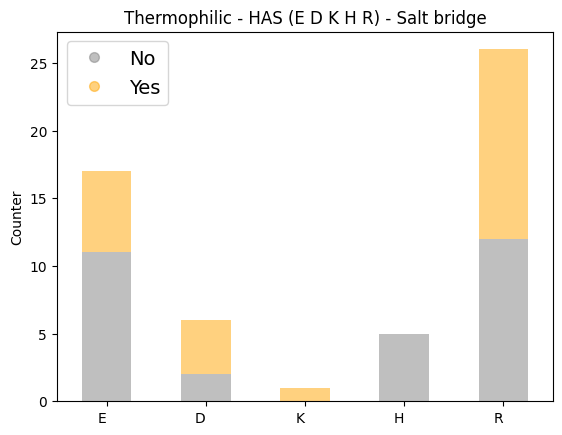

In [33]:
from matplotlib.colors import to_rgba
color_dict = {'nosaltbridge': to_rgba('gray',0.5),'yessaltbridge': to_rgba('orange',0.5)}

ax=HAS_meso_salt_bridge_df.plot.bar(x='AA',stacked=True, title='Thermophilic - HAS (E D K H R) - Salt bridge',color=color_dict)
plt.xticks(rotation=0, ha='right')
ax.set(xlabel=None)
ax.set(ylabel='Counter')

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
                Line2D([], [], marker='.', color= to_rgba('gray',0.5), label='No',
                        markersize=14,linestyle='None'),
                Line2D([], [], marker='.', color=to_rgba('orange',0.5), label='Yes',
                        markersize=14,linestyle='None')
                ]

plt.legend(handles=legend_elements, loc='best',fontsize=14,)
plt.savefig(f'img/SALT_BRIDGE_{label}_HAS.png',dpi=300, bbox_inches = "tight")
plt.savefig(f'img/SALT_BRIDGE_{label}_HAS.svg',format='svg', dpi=300, bbox_inches = "tight")

#### NO HAS

In [34]:
#baseline + has = all
df_all=pd.DataFrame.from_dict(meso_ALL_salt_bridge)
df_all.loc['nosaltbridge'] = df_all.loc['surface'].apply(len) + df_all.loc['core'].apply(len) - df_all.loc['surface'].apply(sum) - df_all.loc['core'].apply(sum)
df_all.loc['yessaltbridge'] =  df_all.loc['surface'].apply(sum) + df_all.loc['core'].apply(sum)
df_all.drop('surface',inplace=True)
df_all.drop('core',inplace=True)
df_all=df_all.transpose()
df_all['AA']=df_all.index
df_all.reset_index(inplace=True)
df_all.drop('index', axis=1, inplace=True)
ALL_meso_salt_bridge=df_all
df_all


,nosaltbridge,yessaltbridge,AA
0,195,120,E
1,112,90,D
2,154,74,K
3,55,28,H
4,112,118,R


In [35]:
# removing has from the baseline
df_nohas=df_all[['nosaltbridge','yessaltbridge']] - has_df[['nosaltbridge','yessaltbridge']]
df_nohas['AA']=df_all['AA']
NOHAS_meso_salt_bridge_df = df_nohas.copy()
df_nohas # 388 215

,nosaltbridge,yessaltbridge,AA
0,184,114,E
1,110,86,D
2,154,73,K
3,50,28,H
4,100,104,R


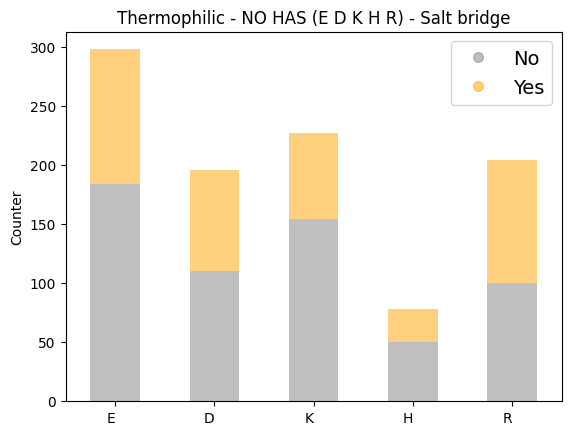

In [36]:
from matplotlib.colors import to_rgba
color_dict = {'nosaltbridge': to_rgba('gray',0.5),'yessaltbridge': to_rgba('orange',0.5)}

ax=NOHAS_meso_salt_bridge_df.plot.bar(x='AA',stacked=True, title='Thermophilic - NO HAS (E D K H R) - Salt bridge',color=color_dict)
plt.xticks(rotation=0, ha='right')
ax.set(xlabel=None)
ax.set(ylabel='Counter')

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
                  Line2D([], [], marker='.', color= to_rgba('gray',0.5), label='No',
                          markersize=14,linestyle='None'),
                  Line2D([], [], marker='.', color=to_rgba('orange',0.5), label='Yes',
                          markersize=14,linestyle='None')
                  ]

plt.legend(handles=legend_elements, loc='best',fontsize=14,)
plt.savefig('img/SALT_BRIDGE_thermo_nohas.png',dpi=300, bbox_inches = "tight")
plt.savefig('img/SALT_BRIDGE_thermo_nohas.svg',format='svg', dpi=300, bbox_inches = "tight")

#### CONCAT

In [37]:
meso_concat_salt_bridge=pd.concat([NOHAS_meso_salt_bridge_df,HAS_meso_salt_bridge_df],axis=1)
meso_concat_salt_bridge.columns = ['no_nohas','yes_nohas','AA','no_has','yes_has','AA_TMP']
meso_concat_salt_bridge.drop('AA_TMP',inplace=True,axis=1)
meso_concat_salt_bridge=meso_concat_salt_bridge[['AA','no_nohas','no_has','yes_nohas','yes_has']]
meso_concat_salt_bridge

,AA,no_nohas,no_has,yes_nohas,yes_has
0,E,184,11,114,6
1,D,110,2,86,4
2,K,154,0,73,1
3,H,50,5,28,0
4,R,100,12,104,14


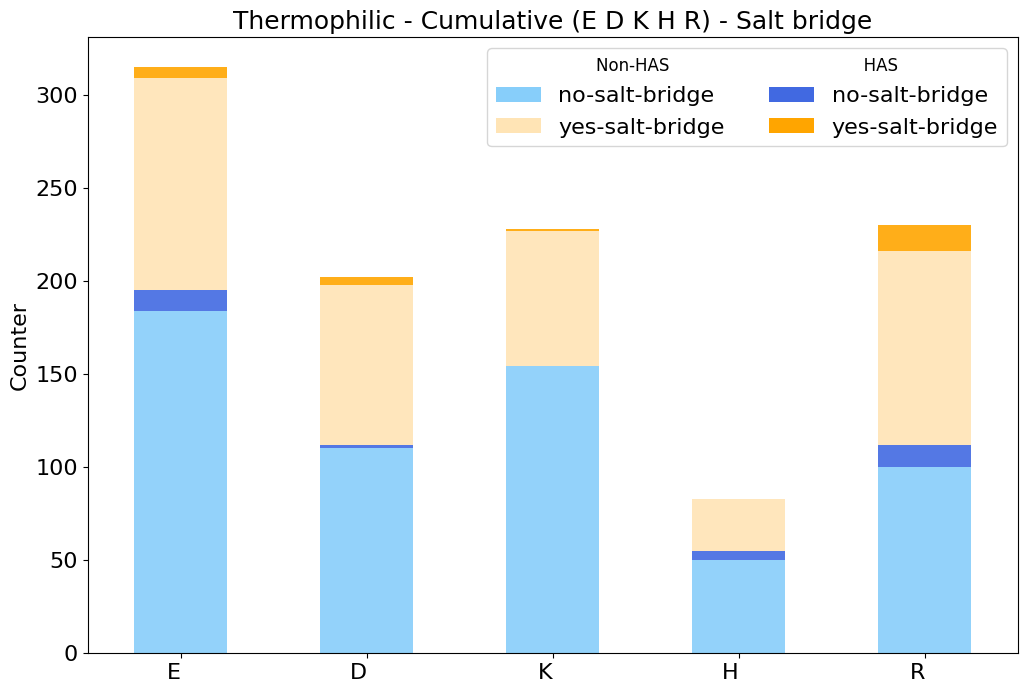

In [38]:
from matplotlib.colors import to_rgba
color_dict = {'no_nohas': to_rgba('lightskyblue',0.9),'yes_nohas': to_rgba('moccasin',0.9),'no_has': to_rgba('royalblue',0.9),'yes_has': to_rgba('orange',0.9)}

ax=meso_concat_salt_bridge.plot.bar(x='AA',stacked=True, title='Thermophilic - Cumulative (E D K H R) - Salt bridge',color=color_dict,figsize=(12, 8))
ax.set_title('Thermophilic - Cumulative (E D K H R) - Salt bridge', fontsize=18)

plt.xticks(rotation=0, ha='right',fontsize=16)
plt.yticks(rotation=0, ha='right',fontsize=16)
ax.set(xlabel=None)
ax.set_ylabel('Counter', fontsize=16)


from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
                Patch(facecolor='lightskyblue',label='no-salt-bridge', ),
                Patch(facecolor= 'moccasin', label='yes-salt-bridge'),
                Patch(facecolor='royalblue', label='no-salt-bridge'),
                Patch(facecolor='orange', label='yes-salt-bridge')
                ]

plt.legend(handles=legend_elements, loc='upper right', ncol=2, title_fontsize='large',title='Non-HAS                                     HAS',fontsize=24,prop={'size': 16} )
plt.savefig('SALT_BRIDGE_thermo_CONCAT.png',dpi=300, bbox_inches = "tight")
plt.savefig('SALT_BRIDGE_thermo_CONCAT.svg',format='svg', dpi=300, bbox_inches = "tight")

### Disulfide bonds analysis

##### HAS

In [39]:
has_df=pd.DataFrame.from_dict(meso_HAS_disulfide)
has_df

,L,A,G,V,E,S,I,K,R,D,T,P,N,Q,F,Y,M,H,C,W
surface,"[0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0]",[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0]",[0],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0]","[0, 0]","[0, 0, 0, 0, 0, 0]",[0],[],"[0, 0, 0, 0]",[0],[0],"[0, 0, 0, 0]",[],[]
core,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",[],"[0, 0, 0, 0, 0, 0, 0]","[0, 0]","[0, 0, 0]","[0, 0, 0, 0, 0, 0]",[0],[],"[0, 0, 0, 0, 0]",[],[0],[0],"[0, 0]",[]


In [40]:
has_df=pd.DataFrame.from_dict(meso_HAS_disulfide)
has_df.loc['nodisulfide'] = has_df.loc['surface'].apply(len) + has_df.loc['core'].apply(len) - has_df.loc['surface'].apply(sum) - has_df.loc['core'].apply(sum)
has_df.loc['yesdisulfide'] =  has_df.loc['surface'].apply(sum) + has_df.loc['core'].apply(sum)
has_df.drop('surface',inplace=True)
has_df.drop('core',inplace=True)
has_df=has_df.transpose()
has_df['AA']=has_df.index
has_df.reset_index(inplace=True)
has_df.drop('index', axis=1, inplace=True)
HAS_meso_disulfide_df=has_df
has_df

,nodisulfide,yesdisulfide,AA
0,14,0,L
1,15,0,A
2,11,0,G
3,9,0,V
4,17,0,E
5,12,0,S
6,13,0,I
7,1,0,K
8,28,0,R
9,6,0,D


##### NO HAS

In [41]:
#baseline + has = all
df_all=pd.DataFrame.from_dict(meso_ALL_disulfide)
df_all.loc['nodisulfide'] = df_all.loc['surface'].apply(len) + df_all.loc['core'].apply(len) - df_all.loc['surface'].apply(sum) - df_all.loc['core'].apply(sum)
df_all.loc['yesdisulfide'] =  df_all.loc['surface'].apply(sum) + df_all.loc['core'].apply(sum)
df_all.drop('surface',inplace=True)
df_all.drop('core',inplace=True)
df_all=df_all.transpose()
df_all['AA']=df_all.index
df_all.reset_index(inplace=True)
df_all.drop('index', axis=1, inplace=True)
ALL_meso_disulfide_df=df_all.copy()
df_all


,nodisulfide,yesdisulfide,AA
0,358,0,L
1,388,0,A
2,317,0,G
3,354,0,V
4,315,0,E
5,167,0,S
6,235,0,I
7,228,0,K
8,230,0,R
9,202,0,D


In [42]:
# removing has from the baseline
df_nohas=df_all[['nodisulfide','yesdisulfide']] - has_df[['nodisulfide','yesdisulfide']]
df_nohas['AA']=df_all['AA']
NOHAS_meso_disulfide_df = df_nohas.copy()
df_nohas # k no 577

,nodisulfide,yesdisulfide,AA
0,344,0,L
1,373,0,A
2,306,0,G
3,345,0,V
4,298,0,E
5,155,0,S
6,222,0,I
7,227,0,K
8,202,0,R
9,196,0,D


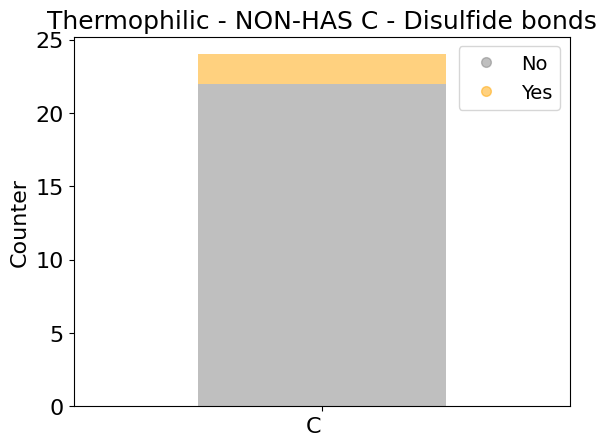

In [43]:
from matplotlib.colors import to_rgba
color_dict = {'nodisulfide': to_rgba('gray',0.5),'yesdisulfide': to_rgba('orange',0.5)}

ax=NOHAS_meso_disulfide_df.loc[NOHAS_meso_disulfide_df['AA']== 'C'].plot.bar(x='AA',stacked=True, title='Thermophilic - NON-HAS C - Disulfide bonds',color=color_dict)

ax.set_title('Thermophilic - NON-HAS C - Disulfide bonds', fontsize=18)
plt.xticks(rotation=0, ha='right',fontsize=16)
plt.yticks(rotation=0, ha='right',fontsize=16)
ax.set(xlabel=None)
ax.set_ylabel('Counter', fontsize=16)

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
                Line2D([], [], marker='.', color= to_rgba('gray',0.5), label='No',
                        markersize=14,linestyle='None'),
                Line2D([], [], marker='.', color=to_rgba('orange',0.5), label='Yes',
                        markersize=14,linestyle='None')
                ]

plt.legend(handles=legend_elements, loc='best',fontsize=14,)
plt.savefig('img/SALT_BRIDGE_thermo_nohas.png',dpi=300, bbox_inches = "tight")
plt.savefig('img/SALT_BRIDGE_thermo_nohas.svg',format='svg', dpi=300, bbox_inches = "tight")

##### CONCAT

In [44]:
meso_concat_disulfide=pd.concat([NOHAS_meso_disulfide_df,HAS_meso_disulfide_df],axis=1)
meso_concat_disulfide.columns = ['no_nohas','yes_nohas','AA','no_has','yes_has','AA_TMP']
meso_concat_disulfide.drop('AA_TMP',inplace=True,axis=1)
meso_concat_disulfide=meso_concat_disulfide[['AA','no_nohas','no_has','yes_nohas','yes_has']]
meso_concat_disulfide

,AA,no_nohas,no_has,yes_nohas,yes_has
0,L,344,14,0,0
1,A,373,15,0,0
2,G,306,11,0,0
3,V,345,9,0,0
4,E,298,17,0,0
5,S,155,12,0,0
6,I,222,13,0,0
7,K,227,1,0,0
8,R,202,28,0,0
9,D,196,6,0,0


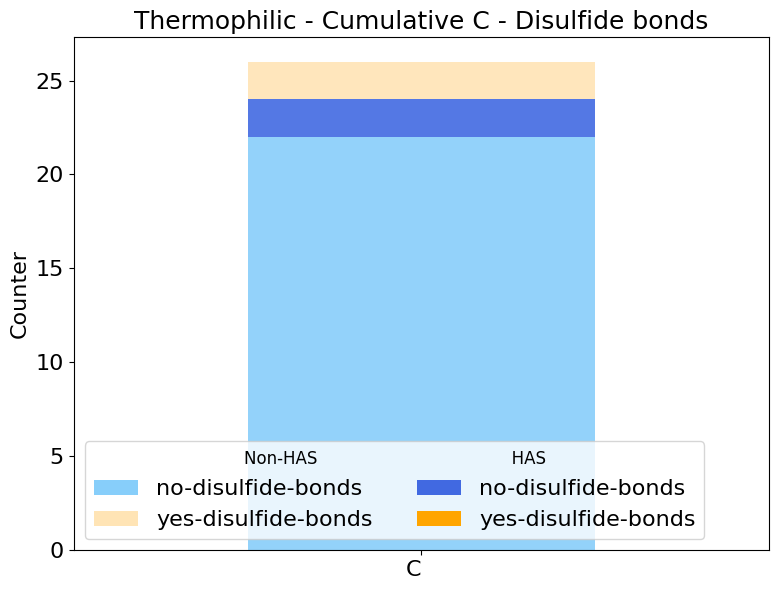

In [45]:
from matplotlib.colors import to_rgba
color_dict = {'no_nohas': to_rgba('lightskyblue',0.9),'yes_nohas': to_rgba('moccasin',0.9),'no_has': to_rgba('royalblue',0.9),'yes_has': to_rgba('orange',0.9)}

ax=meso_concat_disulfide.loc[NOHAS_meso_disulfide_df['AA']== 'C'].plot.bar(x='AA',stacked=True, title='Thermophilic - Cumulative C - Disulfide bonds',color=color_dict,figsize=(8, 6))

ax.set_title('Thermophilic - Cumulative C - Disulfide bonds', fontsize=18)
plt.xticks(rotation=0, ha='right',fontsize=16)
plt.yticks(rotation=0, ha='right',fontsize=16)
ax.set(xlabel=None)
ax.set_ylabel('Counter', fontsize=16)

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
                Patch(facecolor='lightskyblue', label='no-disulfide-bonds', ),
                Patch(facecolor='moccasin', label='yes-disulfide-bonds'),
                Patch(facecolor='royalblue', label='no-disulfide-bonds'),
                Patch(facecolor='orange', label='yes-disulfide-bonds')
                ]

plt.legend(handles=legend_elements, loc='best', ncol=2, title_fontsize='large',title='Non-HAS                                     HAS',fontsize=24,prop={'size': 16} )
plt.tight_layout()

plt.savefig('img/SALT_BRIDGE_thermo_CONCAT.png',dpi=300, bbox_inches = "tight")
plt.savefig('img/SALT_BRIDGE_thermo_CONCAT.svg',format='svg', dpi=300, bbox_inches = "tight")

###  HYDROPHOBIC, CHARGED, POLAR AGGREGATION

In [46]:
pos_charged_aa=['R','K','H']
neg_charged_aa=['D','E']
uncharged_polar_aa=['S','T','N','Q',]
hydrophobic_aa=['A','V','L','I','M']
hydrophobic_aa_withrings=['F','W','Y']
gly=['G']
pro=['P']
cys=['C']
len(hydrophobic_aa) + len(hydrophobic_aa_withrings) + len(pos_charged_aa) + len(uncharged_polar_aa) + len(gly) + len(neg_charged_aa) + len(pro) + len(cys)

20

In [47]:
import copy
meso_baseline_aa_types=copy.deepcopy(meso_baseline_sasa)
meso_HAS_aa_types=copy.deepcopy(meso_HAS_sasa)

#### BASELINE

#1.pos_charged_aa
merged_dict = {}
for key in pos_charged_aa:
    for inner_key, value in meso_baseline_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    meso_baseline_aa_types.pop(key)

meso_baseline_aa_types['pos_charged_aa'] = merged_dict

#2.neg_charged_aa
merged_dict = {}
for key in neg_charged_aa:
    for inner_key, value in meso_baseline_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    meso_baseline_aa_types.pop(key)

meso_baseline_aa_types['neg_charged_aa'] = merged_dict

#3.uncharged_polar_aa
merged_dict = {}
for key in uncharged_polar_aa:
    for inner_key, value in meso_baseline_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    meso_baseline_aa_types.pop(key)

meso_baseline_aa_types['uncharged_polar_aa'] = merged_dict

#4.hydrophobic_aa

merged_dict = {}
for key in hydrophobic_aa:
    for inner_key, value in meso_baseline_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    meso_baseline_aa_types.pop(key)

meso_baseline_aa_types['hydrophobic_aa'] = merged_dict

#5.hydrophobic_aa_withrings
merged_dict = {}
for key in hydrophobic_aa_withrings:
    for inner_key, value in meso_baseline_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    meso_baseline_aa_types.pop(key)

meso_baseline_aa_types['hydrophobic_aa_withrings'] = merged_dict

#6. gly
merged_dict = {}
for key in gly:
    for inner_key, value in meso_baseline_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    meso_baseline_aa_types.pop(key)

meso_baseline_aa_types['gly'] = merged_dict

#7.pro
merged_dict = {}
for key in pro:
    for inner_key, value in meso_baseline_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    meso_baseline_aa_types.pop(key)

meso_baseline_aa_types['pro'] = merged_dict

#8.cys
merged_dict = {}
for key in cys:
    for inner_key, value in meso_baseline_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    meso_baseline_aa_types.pop(key)

meso_baseline_aa_types['cys'] = merged_dict

#### HAS

#1.pos_charged_aa
merged_dict = {}
for key in pos_charged_aa:
    for inner_key, value in meso_HAS_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    meso_HAS_aa_types.pop(key)

meso_HAS_aa_types['pos_charged_aa'] = merged_dict

#2.neg_charged_aa
merged_dict = {}
for key in neg_charged_aa:
    for inner_key, value in meso_HAS_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    meso_HAS_aa_types.pop(key)

meso_HAS_aa_types['neg_charged_aa'] = merged_dict

#3.uncharged_polar_aa
merged_dict = {}
for key in uncharged_polar_aa:
    for inner_key, value in meso_HAS_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    meso_HAS_aa_types.pop(key)

meso_HAS_aa_types['uncharged_polar_aa'] = merged_dict

#4.hydrophobic_aa

merged_dict = {}
for key in hydrophobic_aa:
    for inner_key, value in meso_HAS_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    meso_HAS_aa_types.pop(key)

meso_HAS_aa_types['hydrophobic_aa'] = merged_dict

#5.hydrophobic_aa_withrings
merged_dict = {}
for key in hydrophobic_aa_withrings:
    for inner_key, value in meso_HAS_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    meso_HAS_aa_types.pop(key)

meso_HAS_aa_types['hydrophobic_aa_withrings'] = merged_dict

#6. gly
merged_dict = {}
for key in gly:
    for inner_key, value in meso_HAS_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    meso_HAS_aa_types.pop(key)

meso_HAS_aa_types['gly'] = merged_dict

#7.pro
merged_dict = {}
for key in pro:
    for inner_key, value in meso_HAS_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    meso_HAS_aa_types.pop(key)

meso_HAS_aa_types['pro'] = merged_dict

#8.cys
merged_dict = {}
for key in cys:
    for inner_key, value in meso_HAS_aa_types[key].items():
        if inner_key in merged_dict:
            merged_dict[inner_key] += value
        else:
            merged_dict[inner_key] = value

    meso_HAS_aa_types.pop(key)

meso_HAS_aa_types['cys'] = merged_dict

#check
print(sum(meso_baseline_sasa['S']['surface'])+sum(meso_baseline_sasa['T']['surface']) + sum(meso_baseline_sasa['N']['surface']) + sum(meso_baseline_sasa['Q']['surface']) )
print(sum(meso_baseline_aa_types['uncharged_polar_aa']['surface']))
print(sum(meso_HAS_sasa['C']['core']))
print(sum(meso_HAS_aa_types['cys']['core']))

283
283
2
2


##### FISHER exact test

In [48]:
import numpy as np
from scipy.stats import fisher_exact

meso_aa_types_significant=[]
with open('THERMO_AA_TYPES_fisher_exact.txt', 'a') as f:
  f.write('------------------------------------------------------ \n THERMOPHILIC - Fisher exact test \n------------------------------------------------------ \n')
for aa in meso_baseline_aa_types.keys():
  exposed_high=sum(meso_HAS_aa_types[aa]['surface'])
  buried_high=sum(meso_HAS_aa_types[aa]['core'])
  exposed_low=sum(meso_baseline_aa_types[aa]['surface'])-sum(meso_HAS_aa_types[aa]['surface'])
  buried_low=sum(meso_baseline_aa_types[aa]['core'])-sum(meso_HAS_aa_types[aa]['core'])
  table=np.array([[exposed_high, exposed_low], [buried_high, buried_low]])
  df = pd.DataFrame(table, index=['exposed','buried'], columns=['high att','low att'])
  res = fisher_exact(table, alternative='two-sided')
  significance='SIGNIFICANT (p-value < 0.05)' if res.pvalue < 0.05 else 'non significant (p-value > 0.05)'
  with open('THERMO_AA_TYPES_fisher_exact.txt', 'a') as f:
    dfAsString = df.to_string(header=True, index=True)
    f.write('AA: '+aa+'\n'+dfAsString+'\n'+'p-value: '+ str(res.pvalue)+'\n'+significance+'\n'+'\n')
  if res.pvalue < 0.05 :
    meso_aa_types_significant.append(aa)

with open('THERMO_AA_TYPES_fisher_exact.txt', 'a') as f:
  f.write('------------------------------------------------------ \n AA TYPES WITH SIGNIFICANT P-VALUE: '+' '.join(meso_aa_types_significant)+' \n------------------------------------------------------ \n')

In [49]:
uncharged_polar_aa=['S','T','N','Q',]

In [50]:
meso_HAS_aa_types.keys()

dict_keys(['pos_charged_aa', 'neg_charged_aa', 'uncharged_polar_aa', 'hydrophobic_aa', 'hydrophobic_aa_withrings', 'gly', 'pro', 'cys'])

In [51]:
meso_baseline_aa_types.keys()

dict_keys(['pos_charged_aa', 'neg_charged_aa', 'uncharged_polar_aa', 'hydrophobic_aa', 'hydrophobic_aa_withrings', 'gly', 'pro', 'cys'])

##### Baseline

In [52]:
meso_baseline_aa_types_avgDict={}
meso_baseline_aa_types_avgDict_exposition={'pos_charged_aa':{'surface':[],'core':[]},'neg_charged_aa':{'surface':[],'core':[]},'uncharged_polar_aa':{'surface':[],'core':[]},'hydrophobic_aa':{'surface':[],'core':[]},'hydrophobic_aa_withrings':{'surface':[],'core':[]},'gly':{'surface':[],'core':[]},'pro':{'surface':[],'core':[]},'cys':{'surface':[],'core':[]},}

# 1. sum all the matches for each aa
for k in meso_baseline_aa_types:
  tot_per_aa = sum([sum(meso_baseline_aa_types[k][sec]) for sec in meso_baseline_aa_types[k]])
  meso_baseline_aa_types_avgDict[k]=tot_per_aa
  # 2. compute the percentage of exposition for each aa --> meso_HAS_sasa_avgDict_exposition
  for sec in meso_baseline_aa_types[k]:
    if tot_per_aa != 0:
      meso_baseline_aa_types_avgDict_exposition[k][sec]=sum(meso_baseline_aa_types[k][sec])/(tot_per_aa)
    else:
      meso_baseline_aa_types_avgDict_exposition[k][sec]=0  # 'L': {'surface': , 'core': }

# 3. computing aa percentage on total num aminoacid --> meso_HAS_sasa_avgDict
tot_aa = sum(meso_baseline_aa_types_avgDict.values())
for k,v in (meso_baseline_aa_types_avgDict.items()):
  meso_baseline_aa_types_avgDict[k]= (v)/ tot_aa #'L': 0.09191382578285592  L is the 9% of all the aa

# 4. meso_HAS_sasa_avgDict[k] * meso_HAS_sasa_avgDict_exposition[k][sec] for data visualisation reason --> meso_HAS_sasa_avgDict_exposition_plot
# L_surface * totL * %L in all the data
import copy
meso_baseline_aa_types_avgDict_exposition_plot=copy.deepcopy(meso_baseline_aa_types_avgDict_exposition)
for k in meso_baseline_aa_types_avgDict_exposition_plot:
  for sec in meso_baseline_aa_types_avgDict_exposition_plot[k]:
    meso_baseline_aa_types_avgDict_exposition_plot[k][sec] = meso_baseline_aa_types_avgDict[k] * meso_baseline_aa_types_avgDict_exposition[k][sec]


# to df
meso_baseline_aa_types_avgDict_exposition_plot_df=pd.DataFrame.from_dict(meso_baseline_aa_types_avgDict_exposition_plot)
meso_baseline_aa_types_avgDict_exposition_plot_df=meso_baseline_aa_types_avgDict_exposition_plot_df.transpose()

# to df
meso_baseline_aa_types_avgDict_exposition_df=pd.DataFrame.from_dict(meso_baseline_aa_types_avgDict_exposition)

meso_baseline_aa_types_avgDict_exposition_plot # tutti i valori insieme sommano a 1 somma_totale = sum(sum(inner_dict.values()) for inner_dict in data.values())

{'pos_charged_aa': {'surface': 0.10731833462632531,
  'core': 0.032583397982932506},
 'neg_charged_aa': {'surface': 0.10188776829583657,
  'core': 0.03180760279286268},
 'uncharged_polar_aa': {'surface': 0.07318334626325317,
  'core': 0.07240755107318335},
 'hydrophobic_aa': {'surface': 0.09594000517196793,
  'core': 0.2754072924747867},
 'hydrophobic_aa_withrings': {'surface': 0.024825446082234293,
  'core': 0.046289113007499355},
 'gly': {'surface': 0.04215153866046031, 'core': 0.03982415309025084},
 'pro': {'surface': 0.030256012412723042, 'core': 0.019394879751745538},
 'cys': {'surface': 0.0012929919834497026, 'core': 0.005430566330488751}}

In [57]:
# Funzione per formattare gli x ticks in percentuale
def percentuale_formatter(x, pos):
    return "{:.0f}%".format(x * 100)

from matplotlib.ticker import FuncFormatter
# Applica la formattazione agli x ticks
formatter = FuncFormatter(percentuale_formatter)


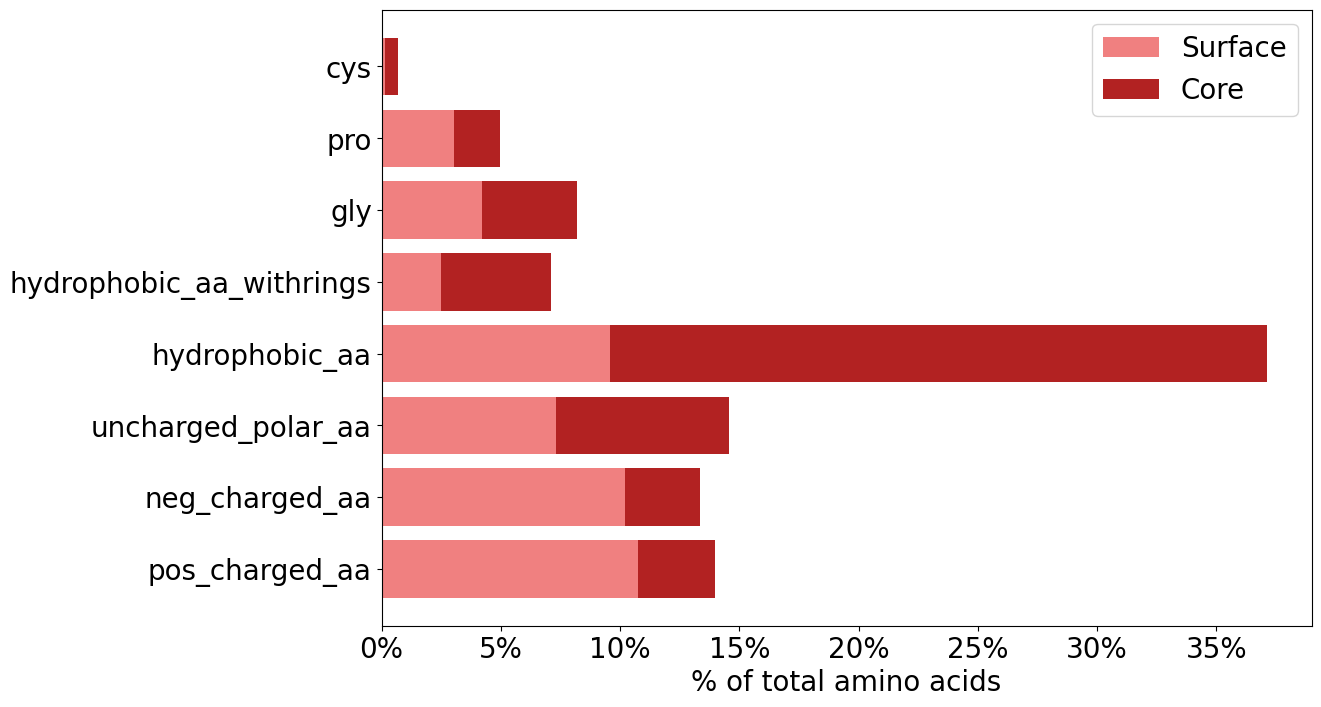

In [66]:
import matplotlib.pyplot as plt

data = meso_baseline_aa_types_avgDict_exposition_plot.copy()

# Estrai le categorie e i valori
categories = list(data.keys())
surface_values = [v['surface'] for v in data.values()]
core_values = [v['core'] for v in data.values()]

# Creazione del plot
fig, ax = plt.subplots(figsize=(12, 8))

# Barre per la superficie
ax.barh(categories, surface_values, color='lightcoral', label='Surface')
# Barre per il core
ax.barh(categories, core_values, left=surface_values, color='firebrick', label='Core')

# Impostazioni del grafico
ax.set_xlabel('% of total amino acids', fontsize=20)  # Imposta la dimensione del carattere per l'etichetta dell'asse x
#ax.set_ylabel('Categories', fontsize=14)  # Imposta la dimensione del carattere per l'etichetta dell'asse y
#ax.set_title('Thermophilic - Distribution of residues on the surface and in the core', fontsize=16)  # Imposta la dimensione del carattere per il titolo
ax.legend(fontsize=20)

# Impostazioni per i tick label
ax.tick_params(axis='both', which='major', labelsize=20)  # Imposta la dimensione del carattere per i tick label


plt.gca().xaxis.set_major_formatter(formatter)

plt.savefig('img/residues_properties_thermo_CONCAT.png',dpi=300, bbox_inches = "tight")
plt.savefig('img/residues_properties_thermo_CONCAT.svg',format='svg', dpi=300, bbox_inches = "tight")


##### HAS

In [59]:
meso_HAS_aa_types_avgDict={}
meso_HAS_aa_types_avgDict_exposition={'pos_charged_aa':{'surface':[],'core':[]},'neg_charged_aa':{'surface':[],'core':[]},'uncharged_polar_aa':{'surface':[],'core':[]},'hydrophobic_aa':{'surface':[],'core':[]},'hydrophobic_aa_withrings':{'surface':[],'core':[]},'gly':{'surface':[],'core':[]},'pro':{'surface':[],'core':[]},'cys':{'surface':[],'core':[]},}

# 1. sum all the matches for each aa
for k in meso_HAS_aa_types:
  tot_per_aa = sum([sum(meso_HAS_aa_types[k][sec]) for sec in meso_HAS_aa_types[k]])
  meso_HAS_aa_types_avgDict[k]=tot_per_aa
  # 2. compute the percentage of exposition for each aa --> meso_HAS_sasa_avgDict_exposition
  for sec in meso_HAS_aa_types[k]:
    if tot_per_aa != 0:
      meso_HAS_aa_types_avgDict_exposition[k][sec]=sum(meso_HAS_aa_types[k][sec])/(tot_per_aa)
    else:
      meso_HAS_aa_types_avgDict_exposition[k][sec]=0

# 3. computing aa percentage on total aminoacid --> meso_HAS_sasa_avgDict
tot_aa = sum(meso_HAS_aa_types_avgDict.values())
for k,v in (meso_HAS_aa_types_avgDict.items()):
  meso_HAS_aa_types_avgDict[k]= (v)/ tot_aa

# 4. meso_HAS_sasa_avgDict[k] * meso_HAS_sasa_avgDict_exposition[k][sec] for data visualisation reason --> meso_HAS_sasa_avgDict_exposition_plot
import copy
meso_HAS_aa_types_avgDict_exposition_plot=copy.deepcopy(meso_HAS_aa_types_avgDict_exposition)
for k in meso_HAS_aa_types_avgDict_exposition_plot:
  for sec in meso_HAS_aa_types_avgDict_exposition_plot[k]:
    meso_HAS_aa_types_avgDict_exposition_plot[k][sec] = meso_HAS_aa_types_avgDict[k] * meso_HAS_aa_types_avgDict_exposition[k][sec]

# to df
meso_HAS_aa_types_avgDict_exposition_plot_df=pd.DataFrame.from_dict(meso_HAS_aa_types_avgDict_exposition_plot)
meso_HAS_aa_types_avgDict_exposition_plot_df=meso_HAS_aa_types_avgDict_exposition_plot_df.transpose()

# to df
meso_HAS_aa_types_avgDict_exposition_df=pd.DataFrame.from_dict(meso_HAS_aa_types_avgDict_exposition)
meso_HAS_aa_types_avgDict_exposition_df

,pos_charged_aa,neg_charged_aa,uncharged_polar_aa,hydrophobic_aa,hydrophobic_aa_withrings,gly,pro,cys
surface,0.75,0.608696,0.388889,0.215686,0.444444,0.363636,0.454545,0.0
core,0.25,0.391304,0.611111,0.784314,0.555556,0.636364,0.545455,1.0


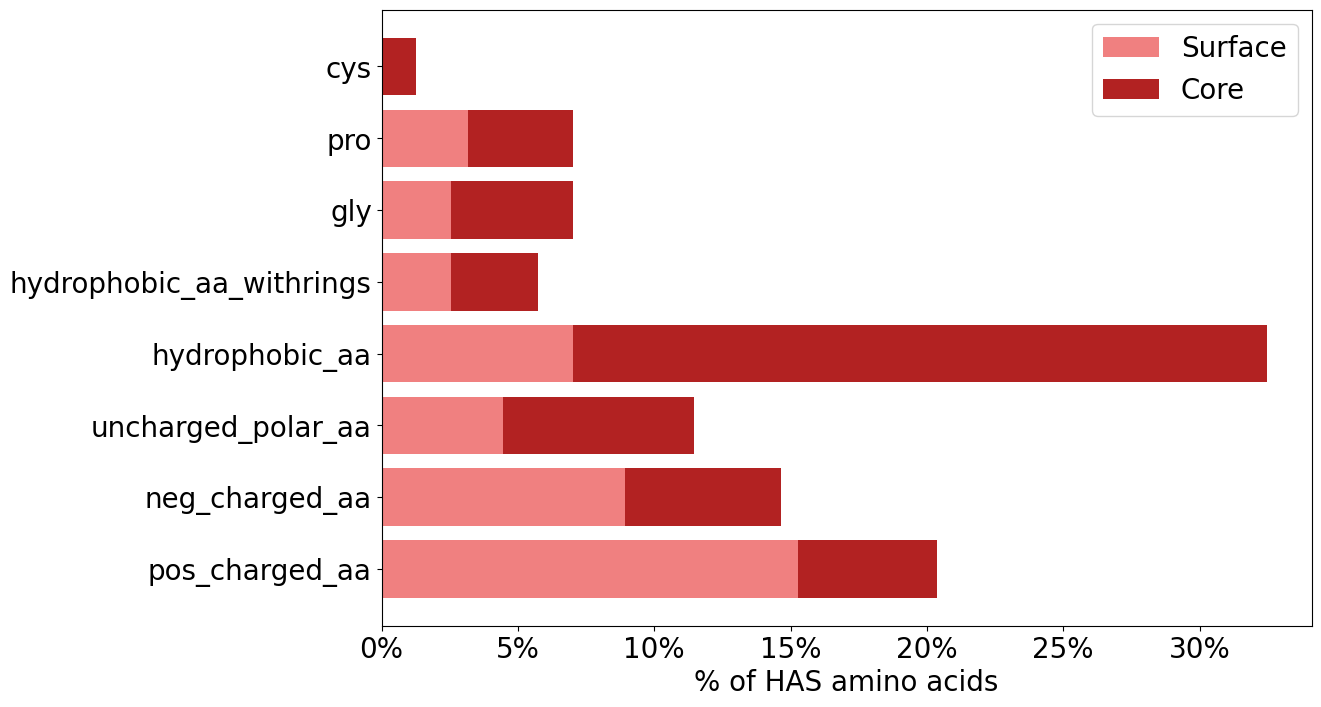

In [63]:
import matplotlib.pyplot as plt

data = meso_HAS_aa_types_avgDict_exposition_plot.copy()

# Estrai le categorie e i valori
categories = list(data.keys())
surface_values = [v['surface'] for v in data.values()]
core_values = [v['core'] for v in data.values()]

# Creazione del plot
fig, ax = plt.subplots(figsize=(12, 8))
#ax.set_title('Thermophilic - Distribution of HAS residues on the surface and in the core', fontsize=16)  # Imposta la dimensione del carattere per il titolo

# Barre per la superficie
ax.barh(categories, surface_values, color='lightcoral', label='Surface')
# Barre per il core
ax.barh(categories, core_values, left=surface_values, color='firebrick', label='Core')

# Impostazioni del grafico
ax.set_xlabel('% of HAS amino acids', fontsize=20)  # Imposta la dimensione del carattere per l'etichetta dell'asse x
#ax.set_ylabel('Categories', fontsize=14)  # Imposta la dimensione del carattere per l'etichetta dell'asse y
#ax.set_title('Thermophilic - Distribution of residues on the surface and in the core', fontsize=16)  # Imposta la dimensione del carattere per il titolo
ax.legend(fontsize=20)

# Impostazioni per i tick label
ax.tick_params(axis='both', which='major', labelsize=20)  # Imposta la dimensione del carattere per i tick label


plt.gca().xaxis.set_major_formatter(formatter)

plt.savefig('img/residues_properties_thermo_HAS.png',dpi=300, bbox_inches = "tight")
plt.savefig('img/residues_properties_thermo_HAS.svg',format='svg', dpi=300, bbox_inches = "tight")


### SASA

##### Baseline

In [56]:
meso_baseline_sasa_avgDict={}
meso_baseline_sasa_avgDict_exposition={'L':{'surface':[],'core':[]},'A':{'surface':[],'core':[]},'G':{'surface':[],'core':[]},'V':{'surface':[],'core':[]},'E':{'surface':[],'core':[]},'S':{'surface':[],'core':[]},'I':{'surface':[],'core':[]},'K':{'surface':[],'core':[]},'R':{'surface':[],'core':[]},'D':{'surface':[],'core':[]},'T':{'surface':[],'core':[]},'P':{'surface':[],'core':[]},'N':{'surface':[],'core':[]},'Q':{'surface':[],'core':[]},'F':{'surface':[],'core':[]},'Y':{'surface':[],'core':[]},'M':{'surface':[],'core':[]},'H':{'surface':[],'core':[]},'C':{'surface':[],'core':[]},'W':{'surface':[],'core':[]},}

# 1. sum all the matches for each aa
for k in meso_baseline_sasa:
  tot_per_aa = sum([sum(meso_baseline_sasa[k][sec]) for sec in meso_baseline_sasa[k]])
  meso_baseline_sasa_avgDict[k]=tot_per_aa #'L': 3443
  # 2. compute the percentage of exposition for each aa --> meso_HAS_sasa_avgDict_exposition
  for sec in meso_baseline_sasa[k]:
    if tot_per_aa != 0:
      meso_baseline_sasa_avgDict_exposition[k][sec]=sum(meso_baseline_sasa[k][sec])/(tot_per_aa)
    else:
      meso_baseline_sasa_avgDict_exposition[k][sec]=0  # 'L': {'surface': 0.2126052860877142, 'core': 0.7873947139122858}

# 3. computing aa percentage on total num aminoacid --> meso_HAS_sasa_avgDict
tot_aa = sum(meso_baseline_sasa_avgDict.values())
for k,v in (meso_baseline_sasa_avgDict.items()):
  meso_baseline_sasa_avgDict[k]= (v)/ tot_aa #'L': 0.09191382578285592  L is the 9% of all the aa

# 4. meso_HAS_sasa_avgDict[k] * meso_HAS_sasa_avgDict_exposition[k][sec] for data visualisation reason --> meso_HAS_sasa_avgDict_exposition_plot
# L_surface * totL * %L in all the data
import copy
meso_baseline_sasa_avgDict_exposition_plot=copy.deepcopy(meso_baseline_sasa_avgDict_exposition)
for k in meso_baseline_sasa_avgDict_exposition_plot:
  for sec in meso_baseline_sasa_avgDict_exposition_plot[k]:
    meso_baseline_sasa_avgDict_exposition_plot[k][sec] = meso_baseline_sasa_avgDict[k] * meso_baseline_sasa_avgDict_exposition[k][sec]

#meso_HAS_sasa
#meso_HAS_sasa_avgDict
#meso_HAS_sasa_avgDict_exposition
#meso_HAS_sasa_avgDict_exposition_plot

# to df
meso_baseline_sasa_avgDict_exposition_plot_df=pd.DataFrame.from_dict(meso_baseline_sasa_avgDict_exposition_plot)
meso_baseline_sasa_avgDict_exposition_plot_df=meso_baseline_sasa_avgDict_exposition_plot_df.transpose()

# to df
meso_baseline_sasa_avgDict_exposition_df=pd.DataFrame.from_dict(meso_baseline_sasa_avgDict_exposition)


In [57]:
meso_baseline_sasa_avgDict_exposition_plot_df

,surface,core
L,0.019136,0.073442
A,0.033359,0.066977
G,0.042152,0.039824
V,0.018619,0.072925
E,0.066977,0.014482
S,0.020171,0.023015
I,0.015257,0.045513
K,0.050685,0.008275
R,0.046289,0.013189
D,0.034911,0.017326


In [58]:
meso_baseline_sasa_avgDict_exposition_df

,L,A,G,V,E,S,I,K,R,D,T,P,N,Q,F,Y,M,H,C,W
surface,0.206704,0.332474,0.514196,0.20339,0.822222,0.467066,0.251064,0.859649,0.778261,0.668317,0.362069,0.609375,0.609023,0.685393,0.265152,0.475248,0.366337,0.481928,0.192308,0.309524
core,0.793296,0.667526,0.485804,0.79661,0.177778,0.532934,0.748936,0.140351,0.221739,0.331683,0.637931,0.390625,0.390977,0.314607,0.734848,0.524752,0.633663,0.518072,0.807692,0.690476


/tmp/ipykernel_3257458/1678207968.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([("{0:.0%}".format(abs(tick))) for tick in ticks],fontsize=16)


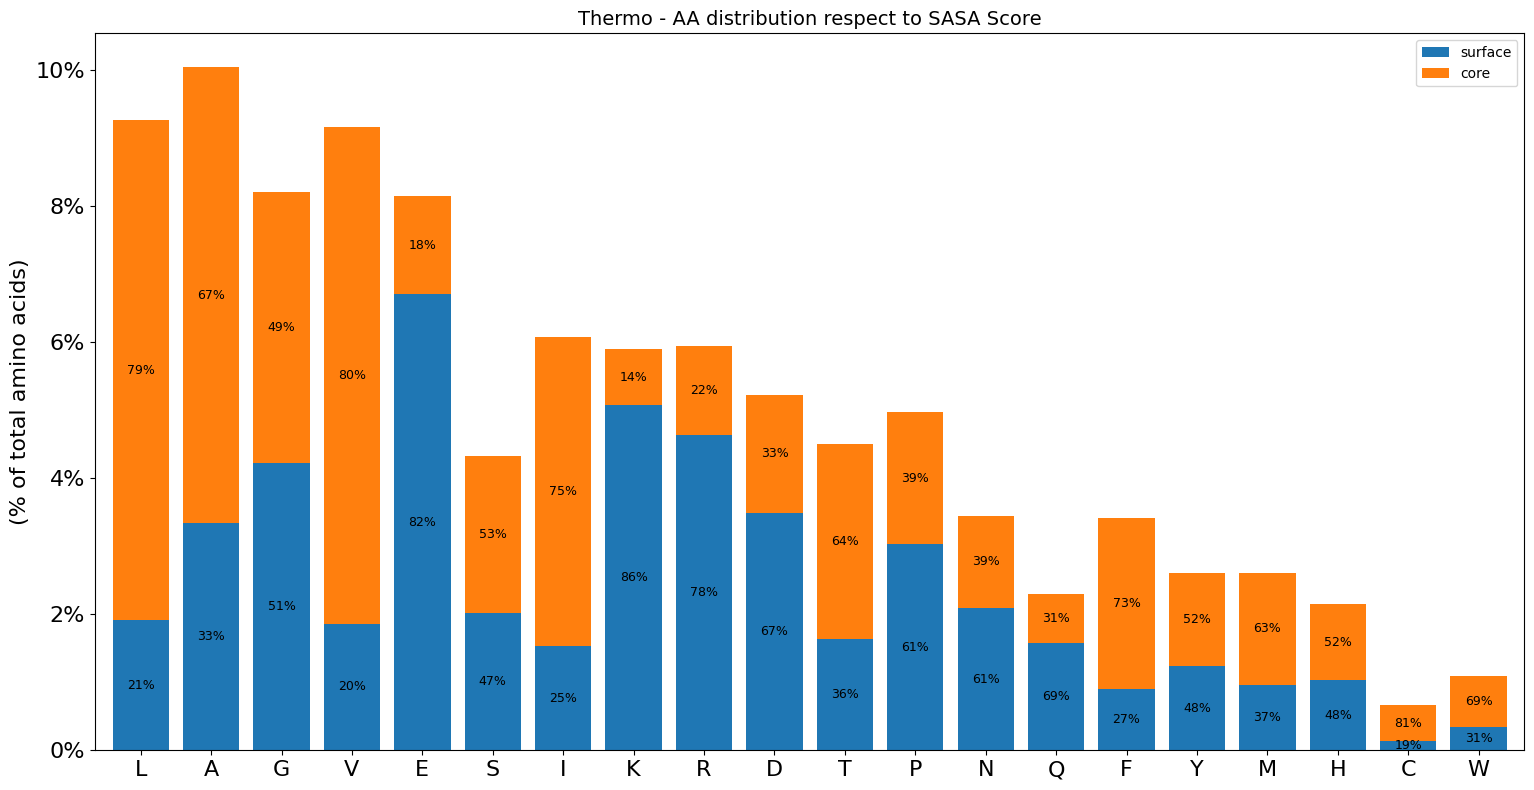

In [59]:
ax=meso_baseline_sasa_avgDict_exposition_plot_df.plot(kind='bar', stacked=True,width=0.8,align='center',figsize=(15, 8))

plt.title('Thermo - AA distribution respect to SASA Score',fontsize=14)

ax.axhline(0, color='black', linewidth=0.5) #adding x ax
# Formatting x labels
plt.xticks(rotation=0,fontsize=16)
plt.tight_layout()

## add annotations
df_row=0
#up plot
for c in ax.containers:
  #[word for sentence in text for word in sentence]
  labels = ["{0:.0%}".format(list(meso_baseline_sasa_avgDict_exposition_df.iloc[df_row])[v]) if list(meso_baseline_sasa_avgDict_exposition_df .iloc[df_row])[v] != 0 else '' for v in range(0,len(c)) ]
  #print(labels)
  df_row+=1
  ax.bar_label(c, labels=labels, fontsize=9,label_type='center')

ticks =  ax.get_yticks()
ax.set_yticklabels([("{0:.0%}".format(abs(tick))) for tick in ticks],fontsize=16)

plt.ylabel("(% of total amino acids)",fontsize=16)
#plt.savefig('Meso_baseline_sasa_score.png')

plt.savefig('img/SASA_thermo.png',dpi=300, bbox_inches = "tight")
plt.savefig('img/SASA_thermo.svg',format='svg', dpi=300, bbox_inches = "tight")

##### Has

In [60]:
meso_HAS_sasa_avgDict={}
meso_HAS_sasa_avgDict_exposition={'L':{'surface':[],'core':[]},'A':{'surface':[],'core':[]},'G':{'surface':[],'core':[]},'V':{'surface':[],'core':[]},'E':{'surface':[],'core':[]},'S':{'surface':[],'core':[]},'I':{'surface':[],'core':[]},'K':{'surface':[],'core':[]},'R':{'surface':[],'core':[]},'D':{'surface':[],'core':[]},'T':{'surface':[],'core':[]},'P':{'surface':[],'core':[]},'N':{'surface':[],'core':[]},'Q':{'surface':[],'core':[]},'F':{'surface':[],'core':[]},'Y':{'surface':[],'core':[]},'M':{'surface':[],'core':[]},'H':{'surface':[],'core':[]},'C':{'surface':[],'core':[]},'W':{'surface':[],'core':[]},}

# 1. sum all the matches for each aa
for k in meso_HAS_sasa:
  tot_per_aa = sum([sum(meso_HAS_sasa[k][sec]) for sec in meso_HAS_sasa[k]])
  meso_HAS_sasa_avgDict[k]=tot_per_aa
  # 2. compute the percentage of exposition for each aa --> meso_HAS_sasa_avgDict_exposition
  for sec in meso_HAS_sasa[k]:
    if tot_per_aa != 0:
      meso_HAS_sasa_avgDict_exposition[k][sec]=sum(meso_HAS_sasa[k][sec])/(tot_per_aa)
    else:
      meso_HAS_sasa_avgDict_exposition[k][sec]=0

# 3. computing aa percentage on total aminoacid --> meso_HAS_sasa_avgDict
tot_aa = sum(meso_HAS_sasa_avgDict.values())
for k,v in (meso_HAS_sasa_avgDict.items()):
  meso_HAS_sasa_avgDict[k]= (v)/ tot_aa

# 4. meso_HAS_sasa_avgDict[k] * meso_HAS_sasa_avgDict_exposition[k][sec] for data visualisation reason --> meso_HAS_sasa_avgDict_exposition_plot
import copy
meso_HAS_sasa_avgDict_exposition_plot=copy.deepcopy(meso_HAS_sasa_avgDict_exposition)
for k in meso_HAS_sasa_avgDict_exposition_plot:
  for sec in meso_HAS_sasa_avgDict_exposition_plot[k]:
    meso_HAS_sasa_avgDict_exposition_plot[k][sec] = meso_HAS_sasa_avgDict[k] * meso_HAS_sasa_avgDict_exposition[k][sec]

#meso_HAS_sasa
#meso_HAS_sasa_avgDict
#meso_HAS_sasa_avgDict_exposition
#meso_HAS_sasa_avgDict_exposition_plot

# to df
meso_HAS_sasa_avgDict_exposition_plot_df=pd.DataFrame.from_dict(meso_HAS_sasa_avgDict_exposition_plot)
meso_HAS_sasa_avgDict_exposition_plot_df=meso_HAS_sasa_avgDict_exposition_plot_df.transpose()

# to df
meso_HAS_sasa_avgDict_exposition_df=pd.DataFrame.from_dict(meso_HAS_sasa_avgDict_exposition)

/tmp/ipykernel_3257458/908525243.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([("{0:.0%}".format(abs(tick))) for tick in ticks],fontsize=16)


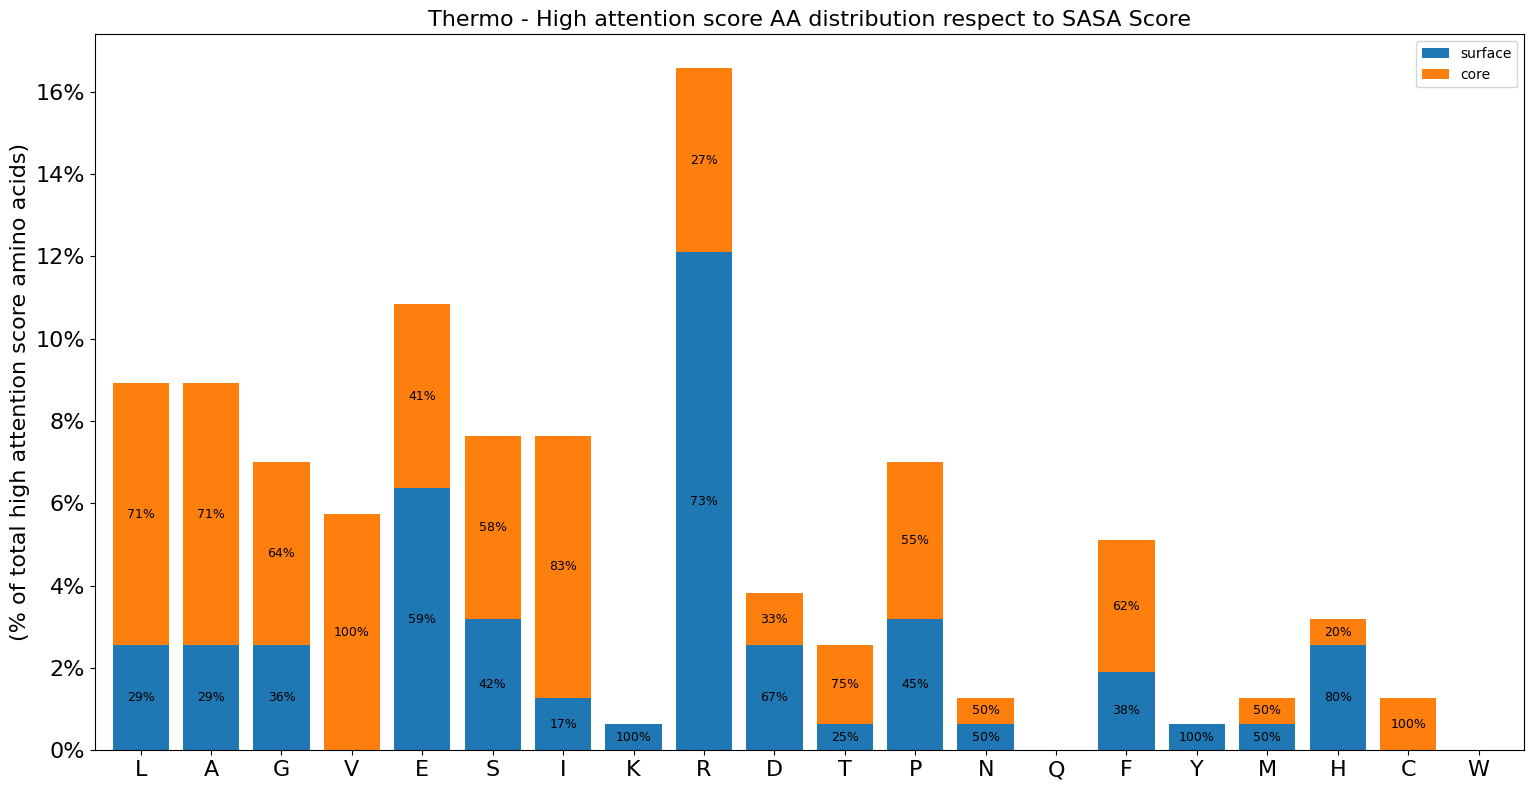

In [61]:
ax=meso_HAS_sasa_avgDict_exposition_plot_df.plot(kind='bar', stacked=True,width=0.8,align='center',figsize=(15, 8))

plt.title('Thermo - High attention score AA distribution respect to SASA Score',fontsize=16)

ax.axhline(0, color='black', linewidth=0.5) #adding x ax
# Formatting x labels
plt.xticks(rotation=0,fontsize=16)
plt.tight_layout()

## add annotations
df_row=0
#up plot
for c in ax.containers:
  #[word for sentence in text for word in sentence]
  labels = ["{0:.0%}".format(list(meso_HAS_sasa_avgDict_exposition_df.iloc[df_row])[v]) if list(meso_HAS_sasa_avgDict_exposition_df .iloc[df_row])[v] != 0 else '' for v in range(0,len(c)) ]
  #print(labels)
  df_row+=1
  ax.bar_label(c, labels=labels, fontsize=9,label_type='center')

ticks =  ax.get_yticks()
ax.set_yticklabels([("{0:.0%}".format(abs(tick))) for tick in ticks],fontsize=16)

plt.ylabel("(% of total high attention score amino acids)",fontsize=16)
#plt.savefig('Meso_HAS_sasa_score.png')

plt.savefig('img/SASA_HAS_thermo.png',dpi=300, bbox_inches = "tight")
plt.savefig('img/SASA_HAS_thermo.svg',format='svg', dpi=300, bbox_inches = "tight")

In [62]:
### FINE NOTEBOOK THERMO

# SAVE THE PROCESSED DATA

In [63]:
# Salva i DataFrame come file pickle
HAS_meso_disulfide_df.to_pickle('HAS_thermo_disulfide_df.pkl')
NOHAS_meso_disulfide_df.to_pickle('NOHAS_thermo_disulfide_df.pkl')
meso_concat_disulfide.to_pickle('thermo_concat_disulfide.pkl')

meso_baseline_sasa_avgDict_exposition_plot_df.to_pickle('thermo_baseline_sasa_avgDict_exposition_plot_df.pkl')
meso_HAS_sasa_avgDict_exposition_plot_df.to_pickle('thermo_HAS_sasa_avgDict_exposition_plot_df.pkl')
meso_baseline_sasa_avgDict_exposition_df.to_pickle('thermo_baseline_sasa_avgDict_exposition_df.pkl')
meso_HAS_sasa_avgDict_exposition_df.to_pickle('thermo_HAS_sasa_avgDict_exposition_df.pkl')

meso_baseline_sasa_avgDict_exposition_plot_df.to_pickle('thermo_baseline_sasa_avgDict_exposition_plot_df.pkl')
meso_HAS_sasa_avgDict_exposition_plot_df.to_pickle('thermo_HAS_sasa_avgDict_exposition_plot_df.pkl')
meso_baseline_sasa_avgDict_exposition_df.to_pickle('thermo_baseline_sasa_avgDict_exposition_df.pkl')
meso_HAS_sasa_avgDict_exposition_df.to_pickle('thermo_HAS_sasa_avgDict_exposition_df.pkl')

meso_baseline_aa_types_avgDict_exposition_plot_df.to_pickle('thermo_baseline_aa_types_avgDict_exposition_plot_df.pkl')
meso_HAS_aa_types_avgDict_exposition_plot_df.to_pickle('thermo_HAS_aa_types_avgDict_exposition_plot_df.pkl')
meso_baseline_aa_types_avgDict_exposition_df.to_pickle('thermo_baseline_aa_types_avgDict_exposition_df.pkl')
meso_HAS_aa_types_avgDict_exposition_df.to_pickle('thermo_HAS_aa_types_avgDict_exposition_df.pkl')


In [64]:
import pandas as pd

# Carica i DataFrame dal file pickle
HAS_thermo_disulfide_df = pd.read_pickle('HAS_thermo_disulfide_df.pkl')
NOHAS_thermo_disulfide_df = pd.read_pickle('NOHAS_thermo_disulfide_df.pkl')
thermo_concat_disulfide = pd.read_pickle('thermo_concat_disulfide.pkl')

thermo_baseline_sasa_avgDict_exposition_plot_df = pd.read_pickle('thermo_baseline_sasa_avgDict_exposition_plot_df.pkl')
thermo_HAS_sasa_avgDict_exposition_plot_df = pd.read_pickle('thermo_HAS_sasa_avgDict_exposition_plot_df.pkl')
thermo_baseline_sasa_avgDict_exposition_df = pd.read_pickle('thermo_baseline_sasa_avgDict_exposition_df.pkl')
thermo_HAS_sasa_avgDict_exposition_df = pd.read_pickle('thermo_HAS_sasa_avgDict_exposition_df.pkl')

thermo_baseline_sasa_avgDict_exposition_plot_df = pd.read_pickle('thermo_baseline_sasa_avgDict_exposition_plot_df.pkl')
thermo_HAS_sasa_avgDict_exposition_plot_df = pd.read_pickle('thermo_HAS_sasa_avgDict_exposition_plot_df.pkl')
thermo_baseline_sasa_avgDict_exposition_df = pd.read_pickle('thermo_baseline_sasa_avgDict_exposition_df.pkl')
thermo_HAS_sasa_avgDict_exposition_df = pd.read_pickle('thermo_HAS_sasa_avgDict_exposition_df.pkl')


thermo_baseline_aa_types_avgDict_exposition_plot_df = pd.read_pickle('thermo_baseline_aa_types_avgDict_exposition_plot_df.pkl')
thermo_HAS_aa_types_avgDict_exposition_plot_df = pd.read_pickle('thermo_HAS_aa_types_avgDict_exposition_plot_df.pkl')
thermo_baseline_aa_types_avgDict_exposition_df = pd.read_pickle('thermo_baseline_aa_types_avgDict_exposition_df.pkl')
thermo_HAS_aa_types_avgDict_exposition_df = pd.read_pickle('thermo_HAS_aa_types_avgDict_exposition_df.pkl')
